# Time Series Analysis 1

In the first lecture, we are mainly concerned with how to manipulate and smooth time series data.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import time

In [3]:
import numpy as np
import pandas as pd

In [4]:
import gmaps
import gmaps.datasets

## Dates and times

### Timestamps

In [5]:
now = pd.to_datetime('now')

In [6]:
now

Timestamp('2019-11-20 20:47:18.395649')

In [7]:
now.year, now.month, now.week, now.day, now.hour, now.minute, now.second, now.microsecond

(2019, 11, 47, 20, 20, 47, 18, 395649)

In [8]:
now.month_name(), now.day_name()

('November', 'Wednesday')

### Formatting timestamps

See format [codes](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior)

In [9]:
now.strftime('%I:%m%p %d-%b-%Y')

'08:11PM 20-Nov-2019'

### Parsing time strings

#### `pandas` can handle standard formats

In [10]:
ts = pd.to_datetime('6-Dec-2018 4:45 PM')

In [11]:
ts

Timestamp('2018-12-06 16:45:00')

#### For unusual formats, use `strptime`

In [12]:
ts = pd.datetime.strptime('10:11PM 02-Nov-2018', '%I:%m%p %d-%b-%Y')

In [13]:
ts

datetime.datetime(2018, 11, 2, 22, 0)

### Intervals

In [14]:
then = pd.to_datetime('now')
time.sleep(5)
now = pd.to_datetime('now')

In [15]:
now - then

Timedelta('0 days 00:00:05.004778')

### Date ranges

A date range is just a collection of time stamps.

In [16]:
dates = pd.date_range(then, now, freq='s')

In [17]:
dates

DatetimeIndex(['2019-11-20 20:47:18.454576', '2019-11-20 20:47:19.454576',
               '2019-11-20 20:47:20.454576', '2019-11-20 20:47:21.454576',
               '2019-11-20 20:47:22.454576', '2019-11-20 20:47:23.454576'],
              dtype='datetime64[ns]', freq='S')

In [18]:
(then - pd.to_timedelta('1.5s')) in dates

False

### Periods

Periods are intervals, not a collection of timestamps.

In [19]:
span = dates.to_period()

In [20]:
span

PeriodIndex(['2019-11-20 20:47:18', '2019-11-20 20:47:19',
             '2019-11-20 20:47:20', '2019-11-20 20:47:21',
             '2019-11-20 20:47:22', '2019-11-20 20:47:23'],
            dtype='period[S]', freq='S')

In [21]:
(then + pd.to_timedelta('1.5s')) in span

True

## Lag and lead with `shift`

We will use a periodic time series as an example. Periodicity is important because many biological phenomena are linked to natural periods (seasons, diurnal, menstrual cycle) or are intrinsically periodic (e.g. EEG, EKG measurements).

In [22]:
index = pd.date_range('1-1-2018', '31-1-2018', freq='12h')

You can shift by periods or by frequency. Shifting by frequency maintains boundary data.

In [23]:
wave = pd.Series(np.sin(np.arange(len(index))), index=index)

In [24]:
wave.shift(periods=1).head(3)

2018-01-01 00:00:00         NaN
2018-01-01 12:00:00    0.000000
2018-01-02 00:00:00    0.841471
Freq: 12H, dtype: float64

In [25]:
wave.shift(periods=1).tail(3)

2018-01-30 00:00:00    0.436165
2018-01-30 12:00:00    0.992873
2018-01-31 00:00:00    0.636738
Freq: 12H, dtype: float64

In [26]:
wave.shift(freq=1).head(3)

/usr/local/lib/python3.7/site-packages/pandas/core/arrays/datetimelike.py:1219: FutureWarning: Addition/subtraction of integers and integer-arrays to DatetimeArray is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  maybe_integer_op_deprecated(self)


2018-01-01 12:00:00    0.000000
2018-01-02 00:00:00    0.841471
2018-01-02 12:00:00    0.909297
Freq: 12H, dtype: float64

In [27]:
wave.shift(freq=1).tail(3)

2018-01-30 12:00:00    0.992873
2018-01-31 00:00:00    0.636738
2018-01-31 12:00:00   -0.304811
Freq: 12H, dtype: float64

#### Visualizing shifts

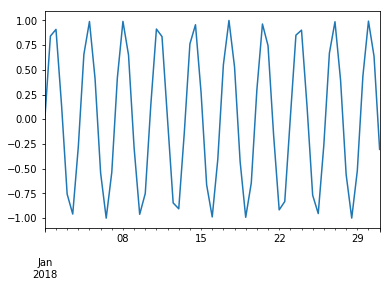

In [28]:
wave.plot()
pass

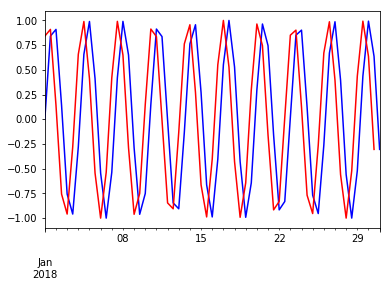

In [29]:
wave.plot(c='blue')
wave.shift(-1).plot(c='red')
pass

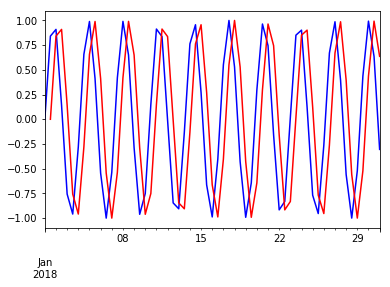

In [30]:
wave.plot(c='blue')
wave.shift(1).plot(c='red')
pass

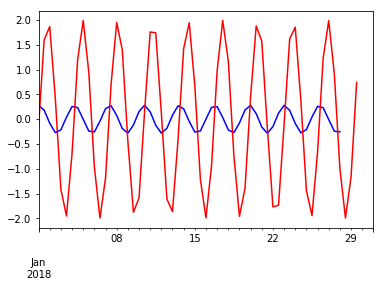

In [31]:
(wave - wave.shift(-6)).plot(c='blue')
(wave - wave.shift(-3)).plot(c='red')
pass

Embedding the time series with its lagged version reveals its periodic nature.

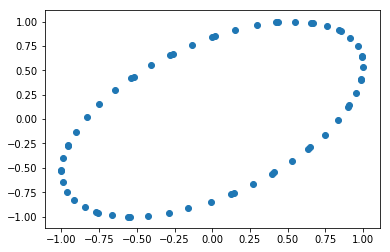

In [32]:
plt.scatter(wave, wave.shift(-1))
pass

### Find percent change from previous period

In [33]:
wave.pct_change().head()

2018-01-01 00:00:00         NaN
2018-01-01 12:00:00         inf
2018-01-02 00:00:00    0.080605
2018-01-02 12:00:00   -0.844803
2018-01-03 00:00:00   -6.362829
Freq: 12H, dtype: float64

`pct_change` is just a convenience wrapper around the use of `shift`

In [34]:
((wave - wave.shift(-1, freq='12h'))/wave).head()

2017-12-31 12:00:00         NaN
2018-01-01 00:00:00        -inf
2018-01-01 12:00:00   -0.080605
2018-01-02 00:00:00    0.844803
2018-01-02 12:00:00    6.362829
Freq: 12H, dtype: float64

## Resampling and window functions


The `resample` and window method have the same syntax as `groupby`, in that you can apply an aggregate function to the new intervals.

### Resampling

Sometimes there is a need to generate new time intervals, for example, to regularize irregularly timed observations.

#### Down-sampling

In [35]:
index = pd.date_range(pd.to_datetime('1-1-2018'), periods=365, freq='d')

In [36]:
series = pd.Series(np.arange(len(index)), index=index)

In [37]:
series.head()

2018-01-01    0
2018-01-02    1
2018-01-03    2
2018-01-04    3
2018-01-05    4
Freq: D, dtype: int64

In [38]:
sereis_weekly_average = series.resample('w').mean()
sereis_weekly_average.head()

2018-01-07     3
2018-01-14    10
2018-01-21    17
2018-01-28    24
2018-02-04    31
Freq: W-SUN, dtype: int64

In [39]:
sereis_monthly_sum = series.resample('m').sum()
sereis_monthly_sum.head()

2018-01-31     465
2018-02-28    1246
2018-03-31    2294
2018-04-30    3135
2018-05-31    4185
Freq: M, dtype: int64

In [40]:
sereis_10day_median = series.resample('10d').median()
sereis_10day_median.head()

2018-01-01     4.5
2018-01-11    14.5
2018-01-21    24.5
2018-01-31    34.5
2018-02-10    44.5
Freq: 10D, dtype: float64

#### Up-sampling

For up-sampling, we need to figure out what we want to do with the missing values. The usual choices are forward fill, backward fill, or interpolation using one of many built-in methods.

In [41]:
upsampled = series.resample('12h')

In [42]:
upsampled.asfreq()[:5]

2018-01-01 00:00:00    0.0
2018-01-01 12:00:00    NaN
2018-01-02 00:00:00    1.0
2018-01-02 12:00:00    NaN
2018-01-03 00:00:00    2.0
Freq: 12H, dtype: float64

In [43]:
upsampled.ffill().head()

2018-01-01 00:00:00    0
2018-01-01 12:00:00    0
2018-01-02 00:00:00    1
2018-01-02 12:00:00    1
2018-01-03 00:00:00    2
Freq: 12H, dtype: int64

In [44]:
upsampled.bfill().head()

2018-01-01 00:00:00    0
2018-01-01 12:00:00    1
2018-01-02 00:00:00    1
2018-01-02 12:00:00    2
2018-01-03 00:00:00    2
Freq: 12H, dtype: int64

In [45]:
upsampled.interpolate('linear').head()

2018-01-01 00:00:00    0.0
2018-01-01 12:00:00    0.5
2018-01-02 00:00:00    1.0
2018-01-02 12:00:00    1.5
2018-01-03 00:00:00    2.0
Freq: 12H, dtype: float64

### Window functions

Window functions are typically used to smooth time series data. There are 3 variants - rolling, expanding and exponentially weighted. We use the Nile flooding data for these examples.

In [46]:
df = pd.read_csv('data/nile.csv', index_col=0)

In [47]:
df.head()

,volume
year,
1871,1120
1872,1160
1873,963
1874,1210
1875,1160


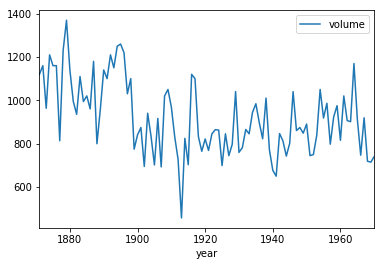

In [48]:
df.plot()
pass

#### Rolling windows generate windows of a specified width

In [49]:
ts = pd.DataFrame(dict(ts=np.arange(5)))
ts['rolling'] = ts.rolling(window=3).sum()
ts

,ts,rolling
0,0,NaN
1,1,NaN
2,2,3.0
3,3,6.0
4,4,9.0


In [50]:
rolling10 = df.rolling(window=10)
rolling100 = df.rolling(window=100)

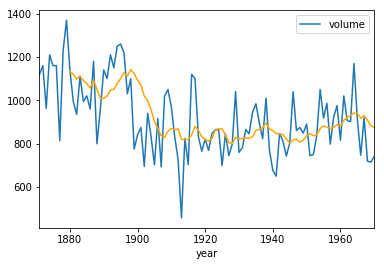

In [51]:
df.plot()
plt.plot(rolling10.mean(), c='orange')
plt.plot(rolling100.mean(), c='red')
pass

#### Expanding windows grow as the time series progresses

In [52]:
ts['expanding'] =  ts.ts.expanding().sum()
ts

,ts,rolling,expanding
0,0,NaN,0.0
1,1,NaN,1.0
2,2,3.0,3.0
3,3,6.0,6.0
4,4,9.0,10.0


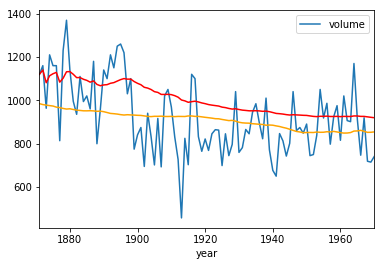

In [53]:
df.plot()
plt.plot(df.expanding(center=True).mean(), c='orange')
plt.plot(df.expanding().mean(), c='red')
pass

#### Exponentially weighted windows place more weight on center of mass

In [54]:
n = 10
xs = np.arange(n, dtype='float')[::-1]
xs

array([9., 8., 7., 6., 5., 4., 3., 2., 1., 0.])

Exponentially weighted windows without adjustment.

In [55]:
pd.Series(xs).ewm(alpha=0.8, adjust=False).mean()

0    9.000000
1    8.200000
2    7.240000
3    6.248000
4    5.249600
5    4.249920
6    3.249984
7    2.249997
8    1.249999
9    0.250000
dtype: float64

Re-implementation for insight.

In [56]:
α = 0.8
ys = np.zeros_like(xs)
ys[0] = xs[0]
for i in range(1, len(xs)):
    ys[i] = (1-α)*ys[i-1] + α*xs[i]
ys

array([9.        , 8.2       , 7.24      , 6.248     , 5.2496    ,
       4.24992   , 3.249984  , 2.2499968 , 1.24999936, 0.24999987])

Exponentially weighted windows with adjustment (default)

In [57]:
pd.Series(xs).ewm(alpha=0.8, adjust=True).mean()

0    9.000000
1    8.166667
2    7.225806
3    6.243590
4    5.248399
5    4.249616
6    3.249910
7    2.249980
8    1.249995
9    0.249999
dtype: float64

Re-implementation for insight.

In [58]:
α = 0.8
ys = np.zeros_like(xs)
ys[0] = xs[0]
for i in range(1, len(xs)):
    ws = np.array([(1-α)**(i-t) for t in range(i+1)])
    ys[i] = (ws * xs[:len(ws)]).sum()/ws.sum()
ys

array([9.        , 8.16666667, 7.22580645, 6.24358974, 5.24839949,
       4.24961598, 3.2499104 , 2.24997952, 1.24999539, 0.24999898])

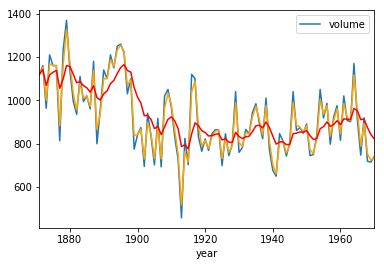

In [59]:
df.plot()
plt.plot(df.ewm(alpha=0.8).mean(), c='orange')
plt.plot(df.ewm(alpha=0.2).mean(), c='red')
pass

Alternatives to $\alpha$

Using `span`
$$
\alpha = \frac{2}{\text{span} + 1}
$$

Using `halflife`
$$
\alpha = 1 - e^\frac{-\log{2}}{t_{1/2}}
$$

Using `com`
$$
\alpha = \frac{1}{1 + \text{com}}
$$


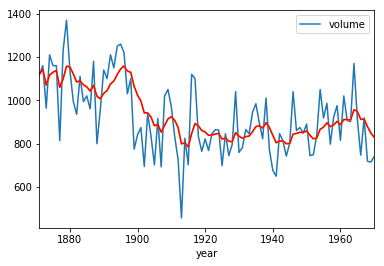

In [60]:
df.plot()
plt.plot(df.ewm(span=10).mean(), c='orange')
plt.plot(1+ df.ewm(alpha=2/11).mean(), c='red') # offfset for visibility
pass

## Correlation between time series

Suppose we had a reference time series. It is often of interest to know how any particular time series is correlated with the reference. Often the reference might be a population average, and we want to see where a particular time series deviates in behavior.

In [61]:
import pandas_datareader.data as web

We will look at the correlation of some stocks.

```
QQQ tracks Nasdaq
MSFT is Microsoft
GOOG is Gogole
BP is British Petroleum
```

We expect that the technology stocks should be correlated with Nasdaq, but maybe not BP.

In [62]:
df = web.DataReader(['QQQ', 'MSFT','GOOG', 'BP'], 'iex',
                    api_key=os.environ['IEX_SECRET_KEY'])

In [63]:
df = df[['close']].reset_index()

In [64]:
df = df.set_index(( 'date',     ''))

In [65]:
df.head()

Attributes   close                      
Symbols        QQQ   MSFT    GOOG     BP
(date, )                                
2014-11-20  103.67  48.70  533.37  41.77
2014-11-21  103.87  47.98  536.03  42.42
2014-11-24  104.68  47.59  537.79  42.04
2014-11-25  104.84  47.47  539.60  41.57
2014-11-26  105.52  47.75  538.89  41.59

In [66]:
df.columns

MultiIndex([('close',  'QQQ'),
            ('close', 'MSFT'),
            ('close', 'GOOG'),
            ('close',   'BP')],
           names=['Attributes', 'Symbols'])

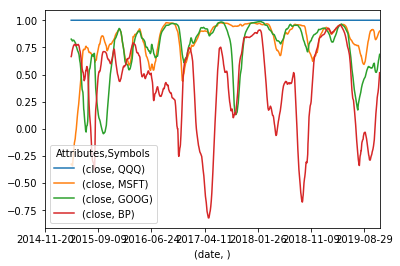

In [67]:
df.rolling(100).corr(df[('close', 'QQQ')]).plot()
pass

## Visualizing space and time data

Being able to visualize events in space and time can be impressive. With Python, often you need a trivial amount of code to produce an impressive visualization.

For example, lets generate a heatmap of crimes in Sacramento in 2006, and highlight the crimes committed 10 seconds before midnight.

See the [gmaps](https://github.com/pbugnion/gmaps) package for more information.

In [68]:
sacramento_crime = pd.read_csv('data/SacramentocrimeJanuary2006.csv', index_col=0)

In [69]:
sacramento_crime.index = pd.to_datetime(sacramento_crime.index)

In [70]:
sacramento_crime.head()

,address,district,beat,grid,crimedescr,ucr_ncic_code,latitude,longitude
cdatetime,,,,,,,,
2006-01-01,3108 OCCIDENTAL DR,3,3C,1115,10851(A)VC TAKE VEH W/O OWNER,2404,38.550420,-121.391416
2006-01-01,2082 EXPEDITION WAY,5,5A,1512,459 PC BURGLARY RESIDENCE,2204,38.473501,-121.490186
2006-01-01,4 PALEN CT,2,2A,212,10851(A)VC TAKE VEH W/O OWNER,2404,38.657846,-121.462101
2006-01-01,22 BECKFORD CT,6,6C,1443,476 PC PASS FICTICIOUS CHECK,2501,38.506774,-121.426951
2006-01-01,3421 AUBURN BLVD,2,2A,508,459 PC BURGLARY-UNSPECIFIED,2299,38.637448,-121.384613


In [71]:
gmaps.configure(api_key=os.environ["GOOGLE_API_KEY"])

In [72]:
locations = sacramento_crime[['latitude', 'longitude']]

In [73]:
late_locations = sacramento_crime.between_time('23:59', '23:59:59')[['latitude', 'longitude']]

In [74]:
fig = gmaps.figure()
fig.add_layer(gmaps.heatmap_layer(locations))
markers = gmaps.marker_layer(late_locations)
fig.add_layer(markers)
fig

Figure(layout=FigureLayout(height='420px'))